# NK Benchmarking

This notebook serves as a user guide to performing the benchmarks outlined in _____. 

In [1]:
""" Python Tools """
import numpy as np 
np.set_printoptions(suppress=True) # Changes print functionality
import pandas as pd

""" Benchmarking Functions """
from Benchmarking.benchmarking_images import generate_extrapolation_plot,gen_interpolation_plot, plot_seq_results, plot_ablation_results
import Benchmarking.interpolation as inter
import Benchmarking.extrapolation as ext
import Benchmarking.ablation as ablation
import Benchmarking.length_dependency as length
import Benchmarking.positional_extrapolation as pos_ext

""" NK Specific Utilities """
from utils.landscape_class import Protein_Landscape
from utils.nk_utils.NK_landscape import makeNK,hamming,collapse_single
from utils.nk_utils.generate_datasets import gen_distance_subsets

""" Sci kit Learn Models """
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import linear_model
from sklearn import svm

""" PyTorch Models """
import torch
from architectures.RNN import RNN
import architectures.DNN as DNN

""" Skorch Packages """
from skorch import NeuralNetRegressor 
from skorch.callbacks import EarlyStopping

from utils.sklearn_utils import save_landscape_dict

from importlib import reload

import pickle as pkl

import matplotlib.pyplot as plt

def load_dict(name):
    with open(name, "rb") as file:
        return pkl.load(file)
    
def save_dict(dictionary,name):
    with open(name, "wb") as f:
        pkl.dump(dictionary, f)


# Device Setup

In [47]:
try:
    device = torch.device('cuda')
    print('Using device:', torch.cuda.get_device_name(0)) 
except: 
    device = torch.device('cpu')

Using device: GeForce RTX 2080 Ti


# Example Model Dictionary

In [7]:
modeldict = {"RF" : (RandomForestRegressor, {'n_jobs':32}),
             "Linear"  :  (linear_model.LinearRegression, {'n_jobs':32}),
             "GB" : (GradientBoostingRegressor, {"n_estimators" : 200,"max_depth" : 5}),
              "MLP" :(MLPRegressor, {"hidden_layer_sizes" : (50,100,50),
                             "activation" : 'relu'}),
              "SVR"  : (BaggingRegressor, {"base_estimator" : svm.SVR(),
                                           "n_estimators"   : 10,
                                          "n_jobs"  : 32}),
              "RNN" : (NeuralNetRegressor, {"module" : RNN(5,32,20,1).double(),
                                   "max_epochs" : 1000,
                                   "lr" : 0.1,
                                   "callbacks" : [EarlyStopping(patience=20)],
                                   "iterator_train__shuffle" : True,
                                   "batch_size" : 128,
                                   "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu')})}

In [8]:
# Load old NK Landscape Dicts
saved_nk_landscapes = {"NK-{}".format(x) : [Protein_Landscape(saved_file="Data/K{0}/V{1}.txt".format(x,y)) for y in range(5)] for x in range(5)}

Data/K0/V0.txt
Data/K0/V1.txt
Data/K0/V2.txt
Data/K0/V3.txt
Data/K0/V4.txt
Data/K1/V0.txt
Data/K1/V1.txt
Data/K1/V2.txt
Data/K1/V3.txt
Data/K1/V4.txt
Data/K2/V0.txt
Data/K2/V1.txt
Data/K2/V2.txt
Data/K2/V3.txt
Data/K2/V4.txt
Data/K3/V0.txt
Data/K3/V1.txt
Data/K3/V2.txt
Data/K3/V3.txt
Data/K3/V4.txt
Data/K4/V0.txt
Data/K4/V1.txt
Data/K4/V2.txt
Data/K4/V3.txt
Data/K4/V4.txt


In [16]:
# Example code to generate experimental landscapes

experimental_dict = {"GProt_Complete" : [Protein_Landscape(csv_path="experimental_csv",seed_seq="MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")],
                     "GProtein_Mut4"   : [Protein_Landscape(csv_path="experimental_csv",seed_seq="MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")],
                     "BLactamase"      : [Protein_Landscape(csv_path="experimental_csv",seed_seq="MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRLYQIADGVWSHIATQSFDGAVYPSNGLIVRDGDELLLIDTAWGAKNTAALLAEIEKQIGLPVTRAVSTHFHDDRVGGVDVLRAAGVATYASPSTRRLAEVEGNEIPTHSLEGLSSSGDAVRFGPVELFYPGAAHSTDNLIVYVPSASVLYGGCAIYELSRTSAGNVADADLAEWPTSIERIQQHYPEAQFVIPGHGLPGGLDLLKHTTNVVKAHTNRSVVE")]}

# Command to save all landscape dictionaries to that they don't have to be regenerated
save_landscape_dict(experimental_dict)



Building Protein Graph for entire dataset


  0%|          | 749/536962 [00:00<01:11, 7480.95it/s]

Calculating the number of extrema


100%|██████████| 536962/536962 [00:10<00:00, 53494.30it/s]



        Protein Landscape class
            Number of Sequences : 536962
            Max Distance        : 2
            Number of Distances : 2
            Seed Sequence       : MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
                Modified positions are shown in green
            Number of minima : 1177
            Number of maxima : 1490
            Normalized Extrema Ruggedness : 0.004966831917342381
            R/S Ruggedness : 4.607086345132251e-10
        
Building Protein Graph for entire dataset


  3%|▎         | 4093/149361 [00:00<00:03, 40927.70it/s]

Calculating the number of extrema


100%|██████████| 149361/149361 [00:03<00:00, 43169.27it/s]



        Protein Landscape class
            Number of Sequences : 149361
            Max Distance        : 4
            Number of Distances : 5
            Seed Sequence       : MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
                Modified positions are shown in green
            Number of minima : 1
            Number of maxima : 182
            Normalized Extrema Ruggedness : 0.0012252194347922149
            R/S Ruggedness : 2.6370513692301434e-11
        
Building Protein Graph for entire dataset


 40%|████      | 2110/5230 [00:00<00:00, 21042.33it/s]

Calculating the number of extrema


100%|██████████| 5230/5230 [00:00<00:00, 21247.60it/s]



        Protein Landscape class
            Number of Sequences : 5230
            Max Distance        : 1
            Number of Distances : 2
            Seed Sequence       : MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRLYQIADGVWSHIATQSFDGAVYPSNGLIVRDGDELLLIDTAWGAKNTAALLAEIEKQIGLPVTRAVSTHFHDDRVGGVDVLRAAGVATYASPSTRRLAEVEGNEIPTHSLEGLSSSGDAVRFGPVELFYPGAAHSTDNLIVYVPSASVLYGGCAIYELSRTSAGNVADADLAEWPTSIERIQQHYPEAQFVIPGHGLPGGLDLLKHTTNVVKAHTNRSVVE
                Modified positions are shown in green
            Number of minima : 161
            Number of maxima : 169
            Normalized Extrema Ruggedness : 0.06309751434034416
            R/S Ruggedness : 16.47846152600471
        


'\nfor land_iter in experimental_dict.values():\n    for instance in land_iter:\n        instance.save()'

In [9]:
print(saved_nk_landscapes["NK-0"][0])


        Protein Landscape class
            Number of Sequences : 100000
            Max Distance        : 5
            Number of Distances : 6
            Seed Sequence       : AAAAA
                Modified positions are shown in green
            Number of minima : 1
            Number of maxima : 1
            Normalized Extrema Ruggedness : 2e-05
            R/S Ruggedness : 30.20584027341869
        


In [10]:
# Example of querying the landscapes
saved_nk_landscapes["NK-0"][0].d_data

{0: array([ True, False, False, ..., False, False, False]),
 1: array([False,  True,  True, ..., False, False, False]),
 2: array([False, False, False, ..., False, False, False]),
 3: array([False, False, False, ..., False, False, False]),
 4: array([False, False, False, ..., False, False, False]),
 5: array([False, False, False, ...,  True,  True,  True])}

# Extrapolation

In [12]:
# Example of how to run positional extrapolation testing

#GProtein_Datasets = {key : value for key,value in saved_experimental_landscapes.items() if key in ["GProtein_Mut4"]}

extrapolation_results = ext.extrapolation(modeldict,saved_nk_landscapes,file_name="NK_Extrapolation",cross_validation=1)

In [25]:
nk_extrapolation_results = load_dict("Results/Extrapolation/Full_NK_Extrapolation_Results.pkl")

In [29]:
Full_Mut4_Results = load_dict("Results/Extrapolation/Full_GProtein_Mut4_Extrapolation_Results.pkl")


In [30]:
saved_interpolation_results = load_dict("Results/Interpolation/Full_NK_Interpolation_Results.pkl")
# Not included in paper

# Ablation Testing

In [ ]:
# Example code for testing ablation

full_ablation_results = ablation.ablation_testing(modeldict,saved_nk_landscapes,file_name="Full_Ablation_NK_Results")

In [33]:
NK_ablation_results = load_dict("Results/Ablation Studies/Full_Ablation_NK_Results.pkl")


In [46]:
experimental_ablation_results = load_dict("Results/Ablation Studies/Full_Experimental_Ablation_Results_NoSVR.pkl")

# Positional Extrapolation

In [43]:
# Example code to test positional extrapolation

from utils.sklearn_utils import reset_params_skorch

positional = Protein_Landscape(saved_file="/home/adam/PhD/Protein_Evolution/RNN/Data/GProtein/Full_GProtein.txt")

positional_extrapolation_small = np.zeros((5,5))
models = [RandomForestRegressor(n_jobs=32),
          linear_model.LinearRegression(n_jobs=32),
          GradientBoostingRegressor(n_estimators=200,max_depth=5),
          MLPRegressor(hidden_layer_sizes=(50,100,50),activation="relu"),
          NeuralNetRegressor(**{"module" : RNN(5,32,20,1).double(),
                                   "max_epochs" : 2000,
                                   "lr" : 0.05,
                                   "callbacks" : [EarlyStopping(patience=10)],
                                   "iterator_train__shuffle" : True,
                                   "batch_size" : 128,
                                   "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu')})]
""",
         BaggingRegressor(base_estimator=svm.SVR(),n_estimators=10,n_jobs=32)] """

positional_split_lengths = [10,20,30,40,50]
for_positions = [list(np.random.choice(range(len(positional.seed_seq)),x,replace=False)) for x in positional_split_lengths]
test_positions = []
for i,pos in enumerate(positional_split_lengths):
    test_positions.append([x for x in range(len(positional.seed_seq)) if x not in for_positions[i]])


#pos_splits2 = [25,50,75,100,125,150,175,200,225,250]

sizes = np.zeros((5,3))

for i,split in enumerate(positional_split_lengths):
    print(for_positions[i][:10])
    train = positional.tokenized[(positional.indexing(positions=for_positions[i]))]
    x_train = train[:,:-1].astype("int")
    y_train = train[:,-1].astype("float")
    sizes[i][0] = len(x_train)
    test = positional.tokenized[(positional.indexing(positions=test_positions[i]))]
    x_test = test[:,:-1].astype("int")
    y_test = test[:,-1].astype("float")
    sizes[i][2] = len(x_test)
    sizes[i][1] = len(positional)-len(x_train)-len(x_test)
    
    
    """print(len(y_test))
    
    for j, model in enumerate(models):
        if model.__class__.__name__ == "NeuralNetRegressor":
            reset_params_skorch(model)
            model.fit(x_train,y_train.reshape(-1,1))
            print(model.score(x_test,y_test.reshape(-1,1)))
            positional_extrapolation_small[i][j] = model.score(x_test,y_test.reshape(-1,1))

        else:
            
            model.fit(x_train,y_train)
            print(model.score(x_test,y_test))
            positional_extrapolation_small[i][j] = model.score(x_test,y_test)"""

    

/home/adam/PhD/Protein_Evolution/RNN/Data/GProtein/Full_GProtein.txt
[34, 11, 14, 52, 50, 4, 7, 33, 38, 37]
[41, 32, 48, 0, 8, 6, 23, 45, 37, 28]
[36, 26, 50, 34, 14, 2, 55, 43, 16, 18]
[8, 9, 15, 20, 50, 53, 14, 25, 39, 22]
[30, 25, 49, 46, 24, 27, 50, 14, 10, 2]


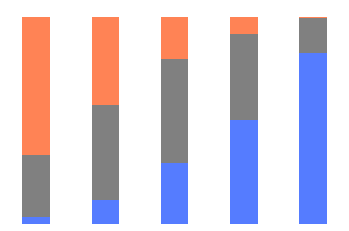

In [44]:
train = sizes[:,0]
omitted = sizes[:,1]
test = sizes[:,2]
ind = np.arange(5)
width=0.4

p1 = plt.bar(ind, train, width,color=(85/255,124/255,255/255))
p2 = plt.bar(ind, omitted, width,bottom=train,color=(0.5,0.5,0.5))
p3 = plt.bar(ind, test, width, bottom=(train+omitted),color=(1,131/255,85/255))
plt.axis("off")
plt.savefig("Data Split.png",bbox_inches="tight",dpi=600)
plt.show()

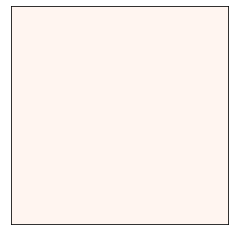

In [6]:
test = np.load("Results/Positional Extrapolation/positional_extrapolation_Gprot_full.npy")

results = test.clip(min=0)
plt.imshow(results,vmin=0,vmax=1,cmap="Reds")

plt.yticks([])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig("Images/Exciting Heatmap.png",dpi=600,bbox_inches="tight")
plt.show()


In [40]:
# This code generates positional extrapolation results using either random splits or sequential splits

from utils.sklearn_utils import reset_params_skorch

positional_extrapolation = np.zeros((10,6))

models = [RandomForestRegressor(n_jobs=32),
          linear_model.LinearRegression(n_jobs=32),
          GradientBoostingRegressor(n_estimators=200,max_depth=5),
          MLPRegressor(hidden_layer_sizes=(50,100,50),activation="relu"),
          BaggingRegressor(base_estimator=svm.SVR(),n_estimators=10,n_jobs=32),
          NeuralNetRegressor(**{"module" : RNN(5,32,20,1).double(),
                                   "max_epochs" : 2000,
                                   "lr" : 0.05,
                                   "callbacks" : [EarlyStopping(patience=20)],
                                   "iterator_train__shuffle" : True,
                                   "batch_size" : 128,
                                   "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu')})] 

positional_splits = [10,20,30,40,50]

for i,split in enumerate(pos_splits2):
    train = positional2.tokenized[(positional2.indexing(positions=[x for x in range(split)]))]
    x_train = train[:,:-1].astype("int")
    y_train = train[:,-1].astype("float")
    test = positional2.tokenized[(positional2.indexing(positions=[x for x in range(split,len(positional2.seed_seq))]))]
    x_test = test[:,:-1].astype("int")
    y_test = test[:,-1].astype("float")
    
    for j, model in enumerate(models):
        if model.__class__.__name__ == "NeuralNetRegressor":
            reset_params_skorch(model)
            model.fit(x_train,y_train.reshape(-1,1))
            positional_extrapolation[i][j] = model.score(x_test,y_test.reshape(-1,1))

        else:
            
            model.fit(x_train,y_train)
            print(model.score(x_test,y_test))
            positional_extrapolation[i][j] = model.score(x_test,y_test) 

-1.2005321584840258
-0.7023427225668522
-0.9964150354108479
-0.6298069622686315
-1.1314063666576217
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       19.0609        5.4183  0.1800
      2        3.8269        8.6696  0.1782
      3        1.7471        5.2989  0.1824
      4        1.2491        6.5875  0.1765
      5        1.1079        5.6825  0.1772
      6        1.1154        6.8563  0.1768
      7        1.1090        5.3487  0.1810
      8        1.1940        6.4933  0.1770
      9        1.2175        5.7591  0.1760
     10        1.1143        6.1473  0.1791
     11        1.1260        5.7182  0.1800
     12        1.1257        6.0178  0.1780
     13        1.1192        6.3825  0.1802
     14        1.1199        6.1361  0.1756
     15        1.2109        5.4277  0.1794
     16        1.1185        6.1200  0.1798
     17        1.1153        6.1986  0.1775
     18        1.1485        5.5604  0.1789
     19        1.132

     51        3.8973        5.5980  0.6625
     52        3.8687        4.6675  0.6603
     53        3.8425        3.0447  0.6660
     54        3.9136        4.0494  0.6597
     55        3.8441        4.7185  0.6594
     56        3.9243        3.3825  0.6604
     57        3.8368        4.0080  0.6572
     58        3.9148        3.8538  0.6657
     59        3.8411        4.0482  0.6655
     60        3.8454        3.5856  0.6607
     61        3.8341        3.9916  0.6602
     62        3.8274        3.6822  0.6652
     63        3.8786        3.7289  0.6612
     64        3.8714        3.9420  0.6626
     65        3.8770        3.5807  0.6617
     66        3.8337        4.7287  0.6599
     67        3.8670        3.6323  0.6648
     68        3.9062        4.5420  0.6610
     69        3.8349        3.8166  0.6823
Stopping since valid_loss has not improved in the last 20 epochs.
-1.0618422059467778
-0.029828106302050017
-0.22064274179422272
-0.01633688715168846
-0.38290833853

     40        4.1830        5.5208  1.3254
     41        4.1820        4.7716  1.3138
Stopping since valid_loss has not improved in the last 20 epochs.
-0.8038003251304557
-0.0025866061421113695
-0.01951182923604522
-0.07006280820977118
-0.16628163590501566
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.9159        4.4688  1.5390
      2        4.2809        3.2885  1.4857
      3        4.3026        3.0527  1.4774
      4        4.1654        5.8961  1.4766
      5        4.1867        4.9085  1.4863
      6        4.1850        2.9401  1.5114
      7        4.1646        4.0149  1.4903
      8        4.1671        6.2632  1.5979
      9        4.1804        5.7774  1.5674
     10        4.1708        4.2113  1.5726
     11        4.1590        4.4754  1.5811
     12        4.1513        4.6575  1.6404
     13        4.1880        4.0129  1.5505
     14        4.1551        4.5235  1.5811
     15  

# Extrema Testing

In [ ]:
# Command examples

# Testing the ruggedness of a subset
test.extrema_ruggedness_subset(test.complex_indexing(distances=[1,2,3,4,5]))

In [115]:
Extrema = np.zeros((5,5))
RS = np.zeros((5,5))

for i,key in enumerate(saved_nk_landscapes.keys()):
    for j,landscape in enumerate(saved_nk_landscapes[key]):
        Extrema[i][j] = landscape.extrema_ruggedness
        RS[i][j] = landscape.RS_ruggedness
        

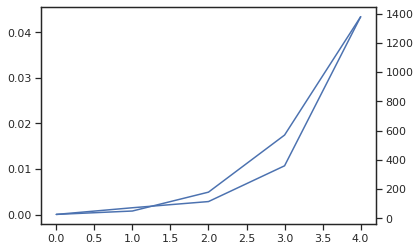

In [116]:
Averaged_Extrema = np.mean(Extrema, axis=1)
Averaged_RS = np.mean(RS,axis=1)
Averaged_RS


sns.lineplot(x=[0,1,2,3,4],y=Averaged_Extrema)
ax2 = plt.twinx()
sns.lineplot(x=[0,1,2,3,4],y=Averaged_RS,ax=ax2)

In [121]:
RS_ext = np.zeros((5,5,5))

for i,key in enumerate(saved_nk_landscapes.keys()):
    for j,landscape in enumerate(saved_nk_landscapes[key]):
        for k,distance in enumerate([range(1,6)[:x+1] for x in range(5)]):
            RS_ext[i,j,k] = landscape.rs_ruggedness(distance=distance)[2]


In [6]:
Extrema_ext = np.zeros((5,5,5))
Extrema_abl = np.zeros((5,5,5))

for i,key in enumerate(saved_nk_landscapes.keys()):
    for j,landscape in enumerate(saved_nk_landscapes[key]):
        print(i,j)
        for k,distance in enumerate([range(1,6)[:x+1] for x in range(5)]):
            Extrema_ext[i,j,k] = landscape.extrema_ruggedness_subset(landscape.complex_indexing(distances=distance))
        for k,split in enumerate([0.1,0.3,0.5,0.7,0.9]):
            Extrema_abl[i,j,k] = landscape.extrema_ruggedness_subset(landscape.complex_indexing(percentage=split))

0 0
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 24880.53it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 46522.36it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 8145



100%|██████████| 8145/8145 [00:00<00:00, 59532.40it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5515/40950 [00:00<00:00, 55145.19it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 58045.54it/s]


Building Protein Graph For subset of length 99999


 11%|█         | 10638/99999 [00:00<00:01, 52662.66it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53955.56it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 71870.12it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 42%|████▏     | 12663/30000 [00:00<00:00, 62030.94it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 62226.80it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5833/50000 [00:00<00:00, 58321.43it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 58833.14it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5392/70000 [00:00<00:01, 53917.09it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 54986.73it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5309/90000 [00:00<00:01, 53085.75it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53866.56it/s]


0 1
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29883.42it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 52894.33it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 57067.41it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 27%|██▋       | 11005/40950 [00:00<00:00, 54746.54it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 57595.38it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5192/99999 [00:00<00:01, 51918.32it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55461.52it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69855.93it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██        | 6349/30000 [00:00<00:00, 63489.00it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65552.80it/s]


Building Protein Graph For subset of length 50000


 11%|█         | 5602/50000 [00:00<00:00, 56013.78it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 57035.76it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5592/70000 [00:00<00:01, 55918.99it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 56927.08it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 11237/90000 [00:00<00:01, 56238.58it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 57276.77it/s]


0 2
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 30097.86it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 44911.39it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 58456.67it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5472/40950 [00:00<00:00, 54711.70it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 57096.93it/s]


Building Protein Graph For subset of length 99999


 11%|█         | 11081/99999 [00:00<00:01, 55359.05it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55476.81it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69858.49it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██▏       | 6375/30000 [00:00<00:00, 63741.25it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63793.35it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5936/50000 [00:00<00:00, 59357.51it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 58907.51it/s]


Building Protein Graph For subset of length 70000


 16%|█▌        | 10954/70000 [00:00<00:01, 54799.96it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55282.63it/s]


Building Protein Graph For subset of length 90000


  6%|▋         | 5790/90000 [00:00<00:01, 57897.02it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 55399.68it/s]


0 3
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 27196.50it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 44776.25it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56875.11it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5358/40950 [00:00<00:00, 53577.75it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 55870.06it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5370/99999 [00:00<00:01, 53690.58it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53886.16it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 68425.81it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6577/30000 [00:00<00:00, 65762.38it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 66171.28it/s]


Building Protein Graph For subset of length 50000


 24%|██▍       | 12129/50000 [00:00<00:00, 60713.58it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 60598.86it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5786/70000 [00:00<00:01, 57857.16it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 57832.41it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5573/90000 [00:00<00:01, 55720.75it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 55642.58it/s]


0 4
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 51639.86it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 47635.95it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56313.72it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 26%|██▌       | 10673/40950 [00:00<00:00, 53184.53it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 55326.05it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5360/99999 [00:00<00:01, 53595.83it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53422.62it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 68764.83it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██        | 6340/30000 [00:00<00:00, 63397.34it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63561.78it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5995/50000 [00:00<00:00, 59940.48it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 58178.11it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5630/70000 [00:00<00:01, 56294.55it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55861.38it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5149/90000 [00:00<00:01, 51488.82it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53376.92it/s]


1 0
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29611.50it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 42857.33it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56688.25it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 26%|██▌       | 10631/40950 [00:00<00:00, 52881.09it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54780.50it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5207/99999 [00:00<00:01, 52065.46it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52865.48it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69046.70it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 42%|████▏     | 12671/30000 [00:00<00:00, 63422.28it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63797.06it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5862/50000 [00:00<00:00, 58612.37it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 59018.86it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5603/70000 [00:00<00:01, 56029.65it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 56226.19it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10855/90000 [00:00<00:01, 54308.25it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54569.11it/s]


1 1
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29500.42it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 47482.06it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 54323.80it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 26%|██▌       | 10521/40950 [00:00<00:00, 52365.13it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54199.26it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5282/99999 [00:00<00:01, 52816.65it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53214.90it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 67722.59it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 43%|████▎     | 12850/30000 [00:00<00:00, 64321.95it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 64016.90it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5877/50000 [00:00<00:00, 58764.87it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 59428.11it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5617/70000 [00:00<00:01, 56160.15it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 56063.25it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10737/90000 [00:00<00:01, 53607.38it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54128.56it/s]


1 2
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 27891.78it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 54355.89it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 57936.50it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 14%|█▎        | 5552/40950 [00:00<00:00, 55519.39it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 58107.30it/s]


Building Protein Graph For subset of length 99999


  6%|▌         | 5543/99999 [00:00<00:01, 55427.67it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55354.52it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 66719.97it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6633/30000 [00:00<00:00, 66326.11it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 66198.82it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 6216/50000 [00:00<00:00, 62156.95it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 62014.38it/s]


Building Protein Graph For subset of length 70000


 16%|█▌        | 11326/70000 [00:00<00:01, 56671.27it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 57267.97it/s]


Building Protein Graph For subset of length 90000


  6%|▋         | 5632/90000 [00:00<00:01, 56316.43it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56996.32it/s]


1 3
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29611.50it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 48304.55it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 55952.08it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5437/40950 [00:00<00:00, 54362.79it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 55233.20it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5170/99999 [00:00<00:01, 51698.32it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52537.71it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 66273.50it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██        | 6305/30000 [00:00<00:00, 63044.05it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 64333.89it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5906/50000 [00:00<00:00, 59056.40it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 59755.77it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5947/70000 [00:00<00:01, 59466.65it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 59417.60it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5560/90000 [00:00<00:01, 55590.25it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56980.09it/s]


1 4
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29167.62it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 46325.25it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 58258.00it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 27%|██▋       | 10980/40950 [00:00<00:00, 54661.20it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56932.31it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5334/99999 [00:00<00:01, 53330.39it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53439.38it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69828.72it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 20%|█▉        | 5938/30000 [00:00<00:00, 59373.12it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 62957.06it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5967/50000 [00:00<00:00, 59669.63it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 59378.17it/s]


Building Protein Graph For subset of length 70000


 16%|█▌        | 11160/70000 [00:00<00:01, 55898.10it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 56318.42it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5388/90000 [00:00<00:01, 53879.02it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53776.31it/s]


2 0
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29541.98it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 46360.58it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56814.39it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 12%|█▏        | 5069/40950 [00:00<00:00, 50688.48it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54725.73it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5227/99999 [00:00<00:01, 52267.93it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53262.57it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 68485.37it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6475/30000 [00:00<00:00, 64748.83it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65226.51it/s]


Building Protein Graph For subset of length 50000


 11%|█▏        | 5745/50000 [00:00<00:00, 57447.04it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 58516.46it/s]


Building Protein Graph For subset of length 70000


 16%|█▌        | 11055/70000 [00:00<00:01, 55407.54it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55362.73it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10650/90000 [00:00<00:01, 53324.02it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54214.03it/s]


2 1
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 30179.67it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 45622.16it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 55836.85it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 26%|██▌       | 10617/40950 [00:00<00:00, 52904.40it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54841.51it/s]


Building Protein Graph For subset of length 99999


 10%|▉         | 9997/99999 [00:00<00:01, 50040.99it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53395.47it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 72265.62it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6465/30000 [00:00<00:00, 64644.36it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65802.74it/s]


Building Protein Graph For subset of length 50000


 24%|██▍       | 11987/50000 [00:00<00:00, 60163.61it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 62041.53it/s]


Building Protein Graph For subset of length 70000


 17%|█▋        | 11720/70000 [00:00<00:00, 58636.60it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58041.55it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5356/90000 [00:00<00:01, 53550.60it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53947.37it/s]


2 2
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 56190.44it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 46595.51it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56646.89it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5243/40950 [00:00<00:00, 52424.68it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54544.12it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5216/99999 [00:00<00:01, 52155.08it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 53034.99it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 70227.06it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6728/30000 [00:00<00:00, 67277.50it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 67720.01it/s]


Building Protein Graph For subset of length 50000


 13%|█▎        | 6257/50000 [00:00<00:00, 62564.69it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61929.61it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5857/70000 [00:00<00:01, 58560.84it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 59221.11it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10689/90000 [00:00<00:01, 53528.88it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54222.55it/s]


2 3
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29546.60it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 43400.38it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56487.47it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 25%|██▌       | 10418/40950 [00:00<00:00, 51594.99it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 53689.89it/s]


Building Protein Graph For subset of length 99999


 10%|█         | 10283/99999 [00:00<00:01, 50890.78it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52875.27it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 68885.67it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6495/30000 [00:00<00:00, 64947.58it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63776.37it/s]


Building Protein Graph For subset of length 50000


 24%|██▍       | 11955/50000 [00:00<00:00, 59801.71it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 60015.24it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5768/70000 [00:00<00:01, 57678.27it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 57489.01it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5500/90000 [00:00<00:01, 54998.74it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54849.41it/s]


2 4
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 33014.46it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 46918.61it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56299.24it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 26%|██▌       | 10443/40950 [00:00<00:00, 51923.15it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54564.96it/s]


Building Protein Graph For subset of length 99999


 10%|█         | 10362/99999 [00:00<00:01, 51794.76it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52915.95it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69286.45it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 20%|██        | 6023/30000 [00:00<00:00, 60223.17it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 62081.46it/s]


Building Protein Graph For subset of length 50000


 11%|█         | 5496/50000 [00:00<00:00, 54957.43it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 55301.80it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5611/70000 [00:00<00:01, 56103.90it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55148.84it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 4980/90000 [00:00<00:01, 49798.74it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54014.01it/s]


3 0
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 24916.66it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 48033.46it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 55978.12it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 25%|██▍       | 10184/40950 [00:00<00:00, 51214.28it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 53551.03it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5228/99999 [00:00<00:01, 52270.95it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52359.29it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 67544.06it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6459/30000 [00:00<00:00, 64586.37it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63563.90it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5830/50000 [00:00<00:00, 58299.08it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 57942.60it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5492/70000 [00:00<00:01, 54915.47it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55106.85it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10707/90000 [00:00<00:01, 53622.62it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53187.33it/s]


3 1
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 54740.05it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 43502.52it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 57699.02it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5418/40950 [00:00<00:00, 54177.86it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56255.70it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5378/99999 [00:00<00:01, 53772.87it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55308.65it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 71042.58it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6527/30000 [00:00<00:00, 65265.08it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 66250.57it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 6119/50000 [00:00<00:00, 61188.31it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61438.89it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5543/70000 [00:00<00:01, 55423.18it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58635.84it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5546/90000 [00:00<00:01, 55450.53it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56311.33it/s]


3 2
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 55496.52it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 44374.56it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 58551.25it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 27%|██▋       | 10985/40950 [00:00<00:00, 54559.94it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56762.18it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5210/99999 [00:00<00:01, 52095.33it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55511.63it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 72441.98it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██        | 6313/30000 [00:00<00:00, 63126.00it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65926.44it/s]


Building Protein Graph For subset of length 50000


 25%|██▍       | 12484/50000 [00:00<00:00, 62214.33it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61858.60it/s]


Building Protein Graph For subset of length 70000


 17%|█▋        | 11752/70000 [00:00<00:00, 58957.38it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58374.23it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 11117/90000 [00:00<00:01, 55581.82it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54477.46it/s]


3 3
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 25253.37it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 42759.22it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56625.95it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 27%|██▋       | 11044/40950 [00:00<00:00, 54902.14it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 57118.21it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5151/99999 [00:00<00:01, 51506.00it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 54504.86it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 73411.96it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6561/30000 [00:00<00:00, 65601.46it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 62315.18it/s]


Building Protein Graph For subset of length 50000


 24%|██▍       | 12022/50000 [00:00<00:00, 59161.31it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61727.40it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5839/70000 [00:00<00:01, 58384.49it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58766.52it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10797/90000 [00:00<00:01, 53825.36it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 52598.00it/s]


3 4
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 28284.68it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 43338.49it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 54680.38it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 27%|██▋       | 11034/40950 [00:00<00:00, 54866.88it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56903.66it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5286/99999 [00:00<00:01, 52857.03it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52954.87it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 70369.15it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 21%|██        | 6335/30000 [00:00<00:00, 63345.53it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63377.66it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5847/50000 [00:00<00:00, 58460.72it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 59648.78it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5644/70000 [00:00<00:01, 56436.42it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 55552.03it/s]


Building Protein Graph For subset of length 90000


 12%|█▏        | 10712/90000 [00:00<00:01, 53522.94it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 54339.30it/s]


4 0
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 29514.26it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 43750.37it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 54934.23it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5197/40950 [00:00<00:00, 51965.96it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54824.81it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5036/99999 [00:00<00:01, 50351.52it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52203.08it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 68317.48it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 43%|████▎     | 12902/30000 [00:00<00:00, 63352.40it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65798.41it/s]


Building Protein Graph For subset of length 50000


 25%|██▌       | 12663/50000 [00:00<00:00, 63269.66it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61342.53it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5663/70000 [00:00<00:01, 56621.82it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 56746.07it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5459/90000 [00:00<00:01, 54582.11it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53988.81it/s]


4 1
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 30059.51it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 48084.98it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 54959.68it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5211/40950 [00:00<00:00, 52104.96it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54827.07it/s]


Building Protein Graph For subset of length 99999


  5%|▍         | 4956/99999 [00:00<00:01, 49553.79it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52078.02it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 64585.38it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 44%|████▍     | 13156/30000 [00:00<00:00, 65934.85it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65846.20it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 6113/50000 [00:00<00:00, 61122.04it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61048.75it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5840/70000 [00:00<00:01, 58397.83it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 59614.73it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5521/90000 [00:00<00:01, 55207.55it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56860.20it/s]


4 2
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 30049.94it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 855


100%|██████████| 855/855 [00:00<00:00, 42413.31it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 57139.28it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5356/40950 [00:00<00:00, 53556.86it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56046.36it/s]


Building Protein Graph For subset of length 99999


  6%|▌         | 5541/99999 [00:00<00:01, 55407.15it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 55351.81it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 73108.94it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6677/30000 [00:00<00:00, 66766.40it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 67243.10it/s]


Building Protein Graph For subset of length 50000


 24%|██▍       | 12211/50000 [00:00<00:00, 61105.24it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 61889.75it/s]


Building Protein Graph For subset of length 70000


 17%|█▋        | 11594/70000 [00:00<00:01, 58042.44it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58065.44it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5150/90000 [00:00<00:01, 51495.26it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 53245.49it/s]


4 3
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 28032.63it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 46761.38it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 56280.14it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5251/40950 [00:00<00:00, 52507.05it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 54786.60it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5236/99999 [00:00<00:01, 52351.06it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 52354.50it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 69689.96it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 20%|█▉        | 5972/30000 [00:00<00:00, 59713.37it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 63698.69it/s]


Building Protein Graph For subset of length 50000


 12%|█▏        | 5953/50000 [00:00<00:00, 59521.26it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 60218.81it/s]


Building Protein Graph For subset of length 70000


  9%|▊         | 5959/70000 [00:00<00:01, 59587.64it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 60313.14it/s]


Building Protein Graph For subset of length 90000


  6%|▌         | 5300/90000 [00:00<00:01, 52995.25it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56554.73it/s]


4 4
Building Protein Graph For subset of length 45


100%|██████████| 45/45 [00:00<00:00, 27776.85it/s]

Calculating the number of extrema
Building Protein Graph For subset of length 855



100%|██████████| 855/855 [00:00<00:00, 52227.98it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 8145


100%|██████████| 8145/8145 [00:00<00:00, 57666.00it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 40950


 13%|█▎        | 5420/40950 [00:00<00:00, 54191.01it/s]

Calculating the number of extrema


100%|██████████| 40950/40950 [00:00<00:00, 56365.88it/s]


Building Protein Graph For subset of length 99999


  5%|▌         | 5447/99999 [00:00<00:01, 54461.74it/s]

Calculating the number of extrema


100%|██████████| 99999/99999 [00:01<00:00, 54611.12it/s]


Building Protein Graph For subset of length 10000


100%|██████████| 10000/10000 [00:00<00:00, 72669.79it/s]

Calculating the number of extrema


Building Protein Graph For subset of length 30000


 22%|██▏       | 6521/30000 [00:00<00:00, 65209.44it/s]

Calculating the number of extrema


100%|██████████| 30000/30000 [00:00<00:00, 65697.16it/s]


Building Protein Graph For subset of length 50000


 13%|█▎        | 6261/50000 [00:00<00:00, 62605.43it/s]

Calculating the number of extrema


100%|██████████| 50000/50000 [00:00<00:00, 62994.75it/s]


Building Protein Graph For subset of length 70000


  8%|▊         | 5851/70000 [00:00<00:01, 58499.87it/s]

Calculating the number of extrema


100%|██████████| 70000/70000 [00:01<00:00, 58868.56it/s]


Building Protein Graph For subset of length 90000


  6%|▋         | 5636/90000 [00:00<00:01, 56357.77it/s]

Calculating the number of extrema


100%|██████████| 90000/90000 [00:01<00:00, 56723.67it/s]


In [83]:
arrays = {"RS Extrapolation" : Averaged_RS_ext,
          "RS Ablation" : Averaged_RS_abl,
          "Extrema Extrapolation" : Averaged_Extrema_ext,
          "Extrema Ablation" : Averaged_Extrema_abl}


NameError: name 'Averaged_RS_ext' is not defined

In [123]:
Averaged_RS_ext = np.mean(RS_ext,axis=1)
Averaged_RS_abl = np.load("RS Ablation.npy")
Averaged_Extrema_ext = np.load("Extrema Extrapolation.npy")
Averaged_Extrema_abl = np.load("Extrema Ablation.npy")
Averaged_RS_ext

array([[  11.03609536,   15.29297151,   18.68143677,   22.11676113,
          25.92917313],
       [   8.36815024,   16.31921791,   27.91952318,   45.32793568,
          71.56736098],
       [  13.67354955,   31.41834941,   63.6470313 ,  106.10157244,
         113.906533  ],
       [   8.3798377 ,   34.1036536 ,  123.00580177,  327.82261236,
         358.7484147 ],
       [  13.10992022,  126.46059133,  404.26737559, 1283.22621804,
        1381.57934441]])

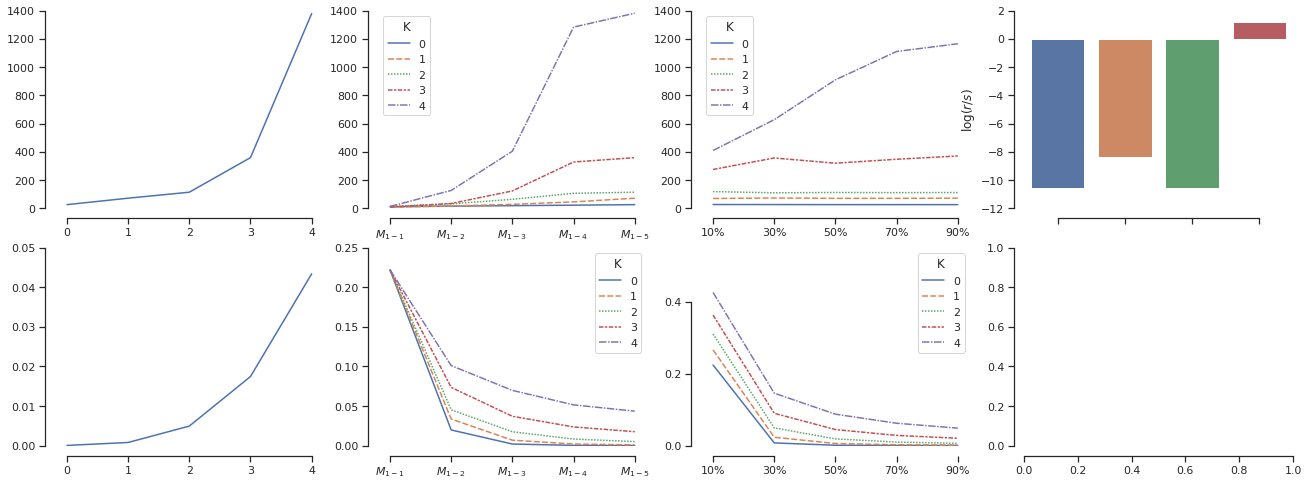

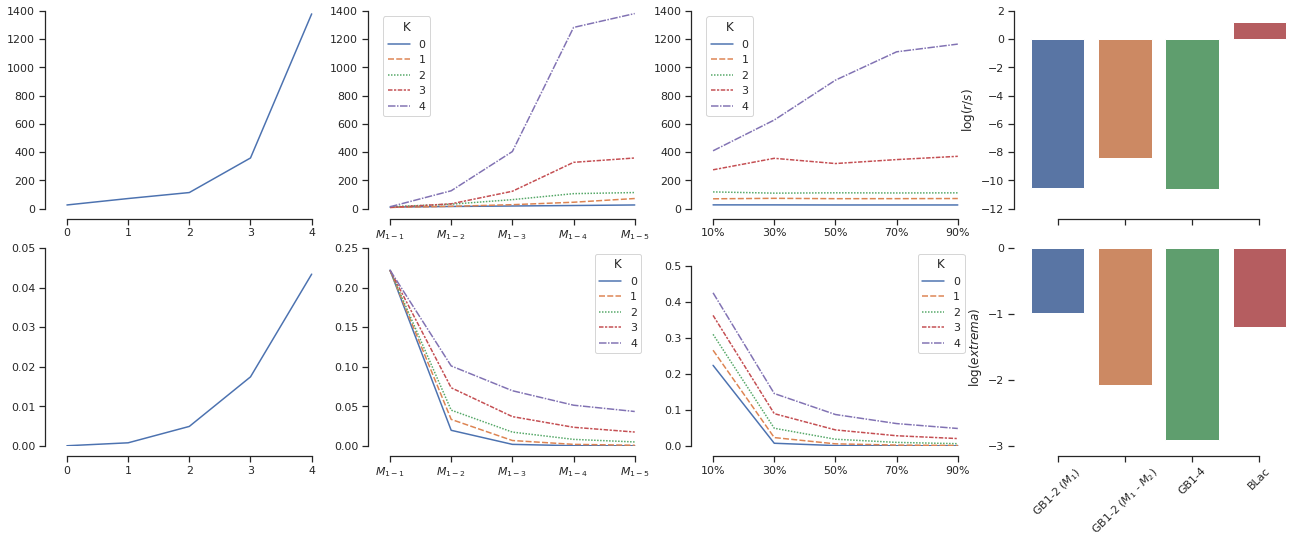

In [142]:
import seaborn as sns ; sns.set()
import matplotlib.pyplot as plt

sns.set_style("ticks")

RS_experimental = {key : np.log10(value[0].RS_ruggedness) for key, value in experimental_dict.items()}
Extrema_experimental = {key : value[0].extrema_ruggedness for key, value in experimental_dict.items()}

labels = ["GB1-2 ($M_1$)", "GB1-2 ($M_1$ - $M_2$)", "GB1-4", "BLac"]
RS_values = [np.log10(value[0].RS_ruggedness) for value in experimental_dict.values()]
Extrema_Values = [np.log10(value[0].extrema_ruggedness) for value in experimental_dict.values()]


Averaged_RS_ext = np.mean(RS_ext,axis=1)
Averaged_RS_abl = np.load("RS Ablation.npy")
Averaged_Extrema_ext = np.load("Extrema Extrapolation.npy")
Averaged_Extrema_abl = np.load("Extrema Ablation.npy")

arrays = {"Averaged RS" : (Averaged_RS, [0,1,2,3,4]),
          "RS Extrapolation" : (Averaged_RS_ext, ["$M_{1-1}$","$M_{1-2}$","$M_{1-3}$","$M_{1-4}$","$M_{1-5}$"]),
          "RS Ablation" : (Averaged_RS_abl, ["10%","30%","50%","70%","90%"]),
          "Experimental RS" : (RS_values, labels),
          "Averaged Extrema" : (Averaged_Extrema, [0,1,2,3,4]),
          "Extrema Extrapolation" : (Averaged_Extrema_ext, ["$M_{1-1}$","$M_{1-2}$","$M_{1-3}$","$M_{1-4}$","$M_{1-5}$"]),
          "Extrema Ablation" : (Averaged_Extrema_abl, ["10%","30%","50%","70%","90%"]),
          "Experimental Extrema" : (Extrema_Values, labels)  }


fig, ((ax1, ax2, ax3,ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16,8))
fig.subplots_adjust(right=1.2)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
i=0
for name, result in arrays.items():
    if name == "Experimental RS":
        sns.barplot(x=result[1],y=result[0],ax=axes[i])
        sns.despine(offset=10, trim=True)
        axes[i].set_xticklabels([])
        axes[i].set_ylim(-12,2)
        axes[i].set_ylabel("$\log({r/s})$")
        axes[i].set_yticks([-12,-10,-8,-6,-4,-2,0,2])
    elif name == "Experimental Extrema":
        sns.barplot(x=result[1],y=result[0],ax=axes[i])
        sns.despine(offset=10, trim=True)
        axes[i].set_ylim(-3,0)
        axes[i].set_ylabel("$\log({extrema})$")
        axes[i].set_yticks([-3,-2,-1,0])
        plt.xticks(rotation=45)
    else:
        sns.lineplot(data=result[0].T,ax=axes[i])
        sns.despine(offset=10, trim=True)
        axes[i].set_xticks(range(len(result[1])))
        axes[i].set_xticklabels(result[1])
        if "Averaged RS" == name:
            axes[i].set_ylim(0,1400)
            axes[i].set_yticks([0,200,400,600,800,1000,1200,1400])
        elif "RS" in name:
            axes[i].legend(title="K")
            axes[i].set_ylim(0,1400)
            axes[i].set_yticks([0,200,400,600,800,1000,1200,1400])
        elif name == "Averaged Extrema":
            axes[i].set_ylim(0,0.05)
            axes[i].set_yticks([0,0.01,0.02,0.03,0.04,0.05])
        elif name == "Extrema Extrapolation":
            axes[i].legend(title="K")
            axes[i].set_ylim(0,0.25)
            axes[i].set_yticks([0,0.05,0.1,0.15,0.2,0.25])
        elif name == "Extrema Ablation":
            axes[i].legend(title="K")
            axes[i].set_ylim(0,0.55)
            axes[i].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
    i+=1
plt.savefig("Ruggedness_Estimators_New.svg")


# Sequence Length

In [26]:
# Example code to examine sequence lengths

full_length_dependence_results = length.length_testing(modeldict,saved_nk_landscapes,seq_lens=[10,20,30,40,50,60,70,80,90,100],file_name="Full_Sequence_Length_NK_Results")

Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 10, RF returned an R-squared of 0.9492760788966276
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 20, RF returned an R-squared of 0.948480970373267
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 30, RF returned an R-squared of 0.9475203921577834
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 40, RF returned an R-squared of 0.9499373195067622
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 50, RF returned an R-squared of 0.9481027615516094
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 60, RF returned an R-squared of 0.9487759736127652
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 70, RF returned an R-squared of 0.9484886903706267
Training model Random

Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 100, RF returned an R-squared of 0.8314872756108453
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 10, RF returned an R-squared of 0.8175098552756491
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 20, RF returned an R-squared of 0.8211190165557961
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 30, RF returned an R-squared of 0.8161115331630449
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 40, RF returned an R-squared of 0.8214869587547888
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 50, RF returned an R-squared of 0.8216959527731548
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 60, RF returned an R-squared of 0.8193307109728233
Training model Rand

Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 90, RF returned an R-squared of 0.6681123614766002
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 100, RF returned an R-squared of 0.6683900567715029
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 10, RF returned an R-squared of 0.689010678625835
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 20, RF returned an R-squared of 0.6911396682068287
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 30, RF returned an R-squared of 0.6870648672813793
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 40, RF returned an R-squared of 0.6861381317620308
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 50, RF returned an R-squared of 0.6923222182070444
Training model Rando

For sequence length 70, RF returned an R-squared of 0.39969186075500907
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 80, RF returned an R-squared of 0.43439233842917535
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 90, RF returned an R-squared of 0.4341821900804028
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 100, RF returned an R-squared of 0.42562900453775376
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 10, RF returned an R-squared of 0.41886700502359364
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 20, RF returned an R-squared of 0.4046854446116894
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 30, RF returned an R-squared of 0.4136138389501046
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence le

Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 60, RF returned an R-squared of -0.14027468417491984
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 70, RF returned an R-squared of -0.13868337911990336
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 80, RF returned an R-squared of -0.14483982041410015
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 90, RF returned an R-squared of -0.13770084390872928
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 100, RF returned an R-squared of -0.13388878006070493
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 10, RF returned an R-squared of -0.13334614569687497
Training model RandomForestRegressor(n_jobs=32) on 80000 data points
For sequence length 20, RF returned an R-squared of -0.12453661120126558
Train

Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 50, Linear returned an R-squared of 0.0453638961423517
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 60, Linear returned an R-squared of 0.04410320202373463
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 70, Linear returned an R-squared of 0.04523846646436658
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 80, Linear returned an R-squared of 0.043628656875762006
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 90, Linear returned an R-squared of 0.04158621257495998
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 100, Linear returned an R-squared of 0.04615391413049952
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 10, Linear returned an R-squared of 0.006843546759548569
Training model Lin

Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 40, Linear returned an R-squared of 0.0018753157005336751
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 50, Linear returned an R-squared of 0.0019957426248156107
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 60, Linear returned an R-squared of 0.002378587705287316
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 70, Linear returned an R-squared of 0.002194772234097475
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 80, Linear returned an R-squared of 0.0020803616453394236
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 90, Linear returned an R-squared of 0.00264616247700189
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 100, Linear returned an R-squared of 0.0018287633658681246
Training 

Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 20, Linear returned an R-squared of 0.0005007742544488325
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 30, Linear returned an R-squared of 0.0006357715202320868
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 40, Linear returned an R-squared of 0.0008496446031303062
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 50, Linear returned an R-squared of 0.000832918364639279
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 60, Linear returned an R-squared of 3.5869546713418465e-05
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 70, Linear returned an R-squared of 0.00024832018525977606
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 80, Linear returned an R-squared of 0.0005884851044100081
Train

Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 100, Linear returned an R-squared of -3.577878792637712e-05
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 10, Linear returned an R-squared of 0.00014973140741858515
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 20, Linear returned an R-squared of 7.873759572607497e-05
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 30, Linear returned an R-squared of 1.1010765875396622e-05
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 40, Linear returned an R-squared of -7.330546088613055e-05
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 50, Linear returned an R-squared of -0.00014187995808989662
Training model LinearRegression(n_jobs=32) on 80000 data points
For sequence length 60, Linear returned an R-squared of 8.345302187551251e-05

Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 40, GB returned an R-squared of 0.9989482657575783
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 50, GB returned an R-squared of 0.9988223997592255
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 60, GB returned an R-squared of 0.9988483149163397
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 70, GB returned an R-squared of 0.9991004256145811
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 80, GB returned an R-squared of 0.9989326953537373
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 90, GB returned an R-squared of 0.9989717717428604
Training model G

For sequence length 40, GB returned an R-squared of 0.8537040761615757
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 50, GB returned an R-squared of 0.844240099878169
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 60, GB returned an R-squared of 0.8403037086590586
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 70, GB returned an R-squared of 0.8590242162167757
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 80, GB returned an R-squared of 0.8572466335997703
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 90, GB returned an R-squared of 0.8510649562929817
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence leng

For sequence length 40, GB returned an R-squared of 0.30502153239657626
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 50, GB returned an R-squared of 0.3145659452687609
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 60, GB returned an R-squared of 0.3087585064804754
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 70, GB returned an R-squared of 0.3090490855742385
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 80, GB returned an R-squared of 0.3156835081214311
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 90, GB returned an R-squared of 0.30757370412486706
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence l

For sequence length 40, GB returned an R-squared of 0.06975996410359264
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 50, GB returned an R-squared of 0.06870298277923437
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 60, GB returned an R-squared of 0.0674946423148528
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 70, GB returned an R-squared of 0.06708129135249075
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 80, GB returned an R-squared of 0.07175130757877679
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 90, GB returned an R-squared of 0.06562547293115661
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequenc

Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 40, GB returned an R-squared of -0.008962893074153877
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 50, GB returned an R-squared of -0.007657901349422014
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 60, GB returned an R-squared of -0.00686205953855179
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 70, GB returned an R-squared of -0.005934173715396174
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 80, GB returned an R-squared of -0.007595992449211497
Training model GradientBoostingRegressor(max_depth=5, n_estimators=200) on 80000 data points
For sequence length 90, GB returned an R-squared of -0.007307829703786073

      2        0.0151        0.0150  8.3488
      3        0.0151        0.0150  8.5818
      4        0.0151        0.0150  8.7709
      5        0.0151        0.0150  8.5085
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 30, RNN returned an R-squared of -0.0005410762160895644
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0159        0.0147  8.7105
      2        0.0140        0.0126  8.7477
      3        0.0119        0.0107  8.5801
      4        0.0111        0.0107  8.4976
      5        0.0107        0.0107  8.5139
      6        0.0105        0.0106  8.6915
      7        0.0104        0.0110  8.39

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0172        0.0131  8.5952
      2        0.0118        0.0113  8.7993
      3        0.0110        0.0107  8.7860
      4        0.0106        0.0103  8.7976
      5        0.0103        0.0103  8.6321
      6        0.0100        0.0100  8.4978
      7        0.0098        0.0096  8.8236
      8        0.0095        0.0094  8.6914
      9        0.0094        0.0104  8.4353
     10        0.0093        0.0089  8.8082
     11        0.0088        0.0071  8.6447
     12        0.0056        0.0037  8.5869
     13        0.0037        0.0029  8.7822
     14        0.0031        0.0035  8.6076
     15        0.0027        0.0020  8.7896
     16        0.0024        0.0021  8.7050
     17        0.0019        0.0024  8.7639
     18        0.0018        0.0014  8.7598
     19        0.0016        0.0013  8.7632
     20        0.0016        0.0011  8.6652
     21        0.0015        0.0

      4        0.0134        0.0132  8.8235
      5        0.0134        0.0131  8.6089
      6        0.0134        0.0137  8.8341
      7        0.0134        0.0131  8.6789
      8        0.0134        0.0132  8.6824
      9        0.0134        0.0132  8.5957
     10        0.0134        0.0131  8.5215
     11        0.0134        0.0131  8.3390
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 20, RNN returned an R-squared of -0.00717159332332562
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0140        0.0134  8.3799
      2        0.0133        0.0135  8.5695
      3        0.0133        0.0137  8.4891

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0140        0.0132  8.5781
      2        0.0132        0.0133  7.3002
      3        0.0132        0.0131  7.8725
      4        0.0131        0.0129  7.1529
      5        0.0127        0.0121  8.6398
      6        0.0113        0.0107  8.8008
      7        0.0105        0.0104  8.6440
      8        0.0104        0.0103  8.6155
      9        0.0103        0.0105  8.7597
     10        0.0101        0.0103  8.7892
     11        0.0100        0.0099  8.7539
     12        0.0098        0.0098  8.8550
     13        0.0096        0.0095  8.5840
     14        0.0093        0.0092  7.7779
     15        0.0091        0.0088  7.1932
     16        0.0089        0.0099  8.5886
     17        0.0087        0.0080  7.2030
     18        0.0085        0.0079  8.6899
     19        0.0084        0.0073  7.3512
     20        0.0080        0.0083  8.6348
     21        0.0078        0.0

     28        0.0006        0.0005  8.5906
     29        0.0006        0.0004  8.5332
     30        0.0005        0.0007  8.4416
     31        0.0005        0.0003  8.5734
     32        0.0005        0.0007  8.6122
     33        0.0004        0.0004  8.5748
     34        0.0004        0.0010  8.5425
     35        0.0004        0.0003  8.5025
     36        0.0003        0.0006  8.5728
     37        0.0003        0.0002  8.5133
     38        0.0003        0.0002  8.6064
     39        0.0003        0.0002  8.4978
     40        0.0003        0.0004  8.6233
     41        0.0002        0.0002  8.5647
     42        0.0002        0.0001  8.6082
     43        0.0002        0.0002  8.5058
     44        0.0002        0.0001  8.4360
     45        0.0002        0.0001  8.6119
     46        0.0002        0.0002  8.6132
     47        0.0002        0.0002  8.5660
     48        0.0001        0.0001  8.4672
     49        0.0001        0.0001  8.5805
     50        0.0001        0.0

     14        0.0098        0.0097  8.2518
     15        0.0097        0.0098  8.5914
     16        0.0097        0.0096  8.6284
     17        0.0096        0.0097  8.6503
     18        0.0096        0.0094  8.7839
     19        0.0095        0.0094  8.7666
     20        0.0095        0.0094  8.7209
     21        0.0094        0.0093  7.4345
     22        0.0094        0.0093  8.0225
     23        0.0094        0.0093  7.6085
     24        0.0093        0.0093  8.5120
     25        0.0092        0.0092  8.5110
     26        0.0092        0.0096  8.4729
     27        0.0092        0.0094  8.4350
     28        0.0091        0.0094  8.4920
     29        0.0091        0.0090  8.5105
     30        0.0091        0.0097  8.4639
     31        0.0091        0.0093  8.0855
     32        0.0090        0.0089  8.2701
     33        0.0090        0.0091  8.1186
     34        0.0090        0.0094  8.1203
     35        0.0089        0.0088  8.1100
     36        0.0089        0.0

     44        0.0032        0.0027  8.4561
     45        0.0030        0.0044  8.1513
     46        0.0027        0.0019  8.2539
     47        0.0025        0.0021  8.1735
     48        0.0022        0.0029  8.1612
     49        0.0020        0.0012  8.1696
     50        0.0019        0.0012  8.1758
     51        0.0016        0.0011  8.3338
     52        0.0015        0.0011  8.3101
     53        0.0013        0.0009  8.1564
     54        0.0012        0.0013  8.1379
     55        0.0011        0.0010  8.1326
     56        0.0010        0.0009  8.2144
     57        0.0009        0.0011  8.1789
     58        0.0008        0.0013  8.2154
     59        0.0008        0.0006  8.2428
     60        0.0007        0.0005  8.0674
     61        0.0007        0.0004  8.0783
     62        0.0006        0.0008  8.1658
     63        0.0006        0.0003  8.1147
     64        0.0006        0.0004  8.3660
     65        0.0005        0.0008  8.3781
     66        0.0005        0.0

      4        0.0111        0.0110  8.2480
      5        0.0110        0.0109  8.2592
      6        0.0110        0.0109  8.2750
      7        0.0109        0.0110  8.1360
      8        0.0109        0.0108  8.1456
      9        0.0108        0.0107  8.1670
     10        0.0107        0.0105  8.4143
     11        0.0105        0.0103  8.1624
     12        0.0103        0.0101  8.1502
     13        0.0102        0.0103  8.1926
     14        0.0100        0.0100  8.1602
     15        0.0099        0.0097  8.2635
     16        0.0098        0.0096  8.3262
     17        0.0097        0.0095  8.3389
     18        0.0097        0.0097  8.3587
     19        0.0095        0.0092  8.2663
     20        0.0093        0.0086  8.1322
     21        0.0089        0.0086  8.2518
     22        0.0083        0.0069  8.1496
     23        0.0067        0.0050  8.2725
     24        0.0047        0.0030  8.1586
     25        0.0035        0.0028  8.3168
     26        0.0029        0.0

     26        0.0017        0.0015  8.1501
     27        0.0016        0.0028  8.2809
     28        0.0015        0.0007  8.3303
     29        0.0013        0.0021  8.3605
     30        0.0012        0.0006  8.2730
     31        0.0010        0.0009  8.0987
     32        0.0010        0.0012  8.4213
     33        0.0010        0.0005  8.1611
     34        0.0008        0.0004  8.1626
     35        0.0008        0.0005  8.2087
     36        0.0007        0.0016  8.1553
     37        0.0007        0.0004  8.2202
     38        0.0007        0.0008  8.2233
     39        0.0006        0.0006  8.2398
     40        0.0006        0.0003  8.2560
     41        0.0006        0.0007  8.3909
     42        0.0005        0.0002  8.1703
     43        0.0005        0.0004  8.1988
     44        0.0004        0.0006  8.1983
     45        0.0005        0.0006  8.3047
     46        0.0004        0.0007  8.2349
Stopping since valid_loss has not improved in the last 5 epochs.
For sequenc

     46        0.0008        0.0004  8.0893
     47        0.0007        0.0004  8.0727
     48        0.0007        0.0008  8.0885
     49        0.0007        0.0007  8.0916
     50        0.0007        0.0007  8.1029
     51        0.0006        0.0005  8.0822
     52        0.0006        0.0003  8.0714
     53        0.0006        0.0004  8.1023
     54        0.0006        0.0005  8.0922
     55        0.0005        0.0005  8.1117
     56        0.0006        0.0004  8.0822
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 80, RNN returned an R-squared of 0.9682233223722038
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
 

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0164        0.0160  8.2659
      2        0.0159        0.0160  8.4173
      3        0.0158        0.0160  8.1496
      4        0.0158        0.0159  8.2196
      5        0.0157        0.0158  8.1524
      6        0.0155        0.0155  8.1496
      7        0.0152        0.0152  8.1307
      8        0.0151        0.0155  8.1485
      9        0.0146        0.0157  8.2489
     10        0.0142        0.0143  8.1413
     11        0.0132        0.0113  8.2534
     12        0.0114        0.0097  8.1790
     13        0.0097        0.0145  8.2884
     14        0.0088        0.0079  8.1532
     15        0.0077        0.0068  8.3252
     16        0.0070        0.0061  8.1796
     17        0.0063        0.0054  8.2401
     18        0.0057        0.0050  8.2022
     19        0.0054        0.0046  8.2198
     20        0.0050        0.0046  8.2193
     21        0.0048        0.0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0164        0.0163  8.5320
      2        0.0160        0.0160  8.5116
      3        0.0160        0.0159  8.4507
      4        0.0160        0.0163  8.5558
      5        0.0160        0.0159  8.5054
      6        0.0160        0.0159  8.4641
      7        0.0159        0.0160  8.5197
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 40, RNN returned an R-squared of -0.0009075002289631318
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0169        0.0159  8.4654
      2        0.0159        0.0159  8.48

     14        0.0066        0.0066  8.5177
     15        0.0061        0.0056  8.4675
     16        0.0055        0.0044  8.4217
     17        0.0050        0.0046  8.4909
     18        0.0045        0.0044  8.4745
     19        0.0040        0.0031  8.5194
     20        0.0036        0.0032  8.4895
     21        0.0033        0.0027  8.4474
     22        0.0030        0.0023  8.4638
     23        0.0027        0.0040  8.5066
     24        0.0025        0.0021  8.3542
     25        0.0022        0.0025  7.9793
     26        0.0019        0.0025  8.2044
     27        0.0017        0.0024  8.1779
     28        0.0016        0.0015  8.3026
     29        0.0014        0.0009  8.3317
     30        0.0012        0.0008  8.0382
     31        0.0012        0.0017  8.1638
     32        0.0010        0.0017  8.0671
     33        0.0010        0.0006  8.2490
     34        0.0009        0.0011  8.2418
     35        0.0008        0.0006  8.0980
     36        0.0008        0.0

      4        0.0166        0.0166  7.9603
      5        0.0165        0.0163  8.1202
      6        0.0165        0.0163  8.2660
      7        0.0165        0.0170  7.7701
      8        0.0165        0.0164  8.0026
      9        0.0165        0.0163  8.2948
     10        0.0165        0.0164  8.3284
     11        0.0165        0.0164  8.4215
     12        0.0165        0.0163  8.4270
     13        0.0164        0.0163  8.3439
     14        0.0164        0.0165  8.3870
     15        0.0164        0.0163  8.5475
     16        0.0164        0.0164  8.4121
     17        0.0164        0.0163  8.3905
     18        0.0164        0.0167  8.4518
     19        0.0164        0.0163  8.3889
     20        0.0164        0.0163  8.7132
     21        0.0164        0.0163  8.4365
     22        0.0164        0.0163  8.7121
     23        0.0164        0.0163  8.3538
     24        0.0164        0.0164  8.4166
     25        0.0164        0.0163  8.6481
     26        0.0164        0.0

     22        0.0149        0.0148  8.3485
     23        0.0149        0.0148  8.6929
     24        0.0149        0.0149  8.5148
     25        0.0149        0.0148  8.3945
     26        0.0149        0.0148  8.5397
     27        0.0148        0.0148  7.4726
     28        0.0148        0.0147  6.9259
     29        0.0148        0.0147  6.7495
     30        0.0148        0.0150  8.2272
     31        0.0148        0.0150  8.2740
     32        0.0148        0.0148  7.2204
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 10, RNN returned an R-squared of 0.09618812566626278
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------


      2        0.0165        0.0165  8.5391
      3        0.0164        0.0165  8.1387
      4        0.0164        0.0165  7.1507
      5        0.0165        0.0165  6.7333
      6        0.0165        0.0165  6.6140
      7        0.0165        0.0165  6.6657
      8        0.0165        0.0165  6.8179
      9        0.0165        0.0165  8.0641
     10        0.0165        0.0165  8.3955
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 40, RNN returned an R-squared of 1.7771717941705845e-07
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0181        0.0163  8.4761
      2        0.0167        0.0162  7.80

      2        0.0173        0.0181  7.9599
      3        0.0173        0.0177  7.9905
      4        0.0172        0.0171  8.2484
      5        0.0172        0.0171  8.2005
      6        0.0172        0.0171  8.3760
      7        0.0171        0.0171  8.4524
      8        0.0171        0.0171  8.0987
      9        0.0171        0.0171  8.3193
     10        0.0171        0.0171  8.0957
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 10, RNN returned an R-squared of -1.0758604849225861e-06
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0186        0.0170  8.0362
      2        0.0170        0.0168  8.0

      2        0.0168        0.0168  8.6811
      3        0.0168        0.0168  8.7041
      4        0.0168        0.0166  8.5424
      5        0.0168        0.0165  8.2815
      6        0.0167        0.0171  8.3627
      7        0.0167        0.0166  8.2549
      8        0.0167        0.0166  7.0577
      9        0.0167        0.0166  7.3118
     10        0.0167        0.0165  6.7775
     11        0.0167        0.0166  6.8974
     12        0.0167        0.0166  6.7747
     13        0.0166        0.0166  7.3690
     14        0.0167        0.0165  8.2303
     15        0.0167        0.0165  7.9015
     16        0.0167        0.0165  8.5440
     17        0.0166        0.0166  8.4819
     18        0.0167        0.0166  8.5566
     19        0.0166        0.0165  8.4016
     20        0.0167        0.0165  7.7429
     21        0.0166        0.0165  8.4700
     22        0.0166        0.0165  8.4786
     23        0.0166        0.0167  8.5492
     24        0.0166        0.0

     56        0.0160        0.0160  8.2362
     57        0.0160        0.0160  8.2946
     58        0.0159        0.0162  8.2547
     59        0.0159        0.0160  8.2917
     60        0.0159        0.0166  8.2005
     61        0.0159        0.0164  8.4089
     62        0.0159        0.0160  8.4508
     63        0.0158        0.0161  8.4111
     64        0.0158        0.0159  8.3124
     65        0.0158        0.0158  8.3197
     66        0.0158        0.0159  8.2899
     67        0.0158        0.0158  8.1397
     68        0.0157        0.0158  8.2682
     69        0.0157        0.0160  8.3494
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 80, RNN returned an R-squared of 0.06971926499823922
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_feature

     73        0.0123        0.0124  8.0083
     74        0.0122        0.0115  8.0593
     75        0.0120        0.0125  7.4159
     76        0.0120        0.0114  8.2954
     77        0.0118        0.0116  7.4122
     78        0.0117        0.0113  7.7798
     79        0.0116        0.0110  8.0295
     80        0.0115        0.0116  8.1091
     81        0.0114        0.0108  7.4257
     82        0.0113        0.0107  7.7684
     83        0.0112        0.0106  8.0445
     84        0.0110        0.0104  8.0740
     85        0.0109        0.0103  7.9569
     86        0.0109        0.0102  8.0722
     87        0.0107        0.0099  8.3113
     88        0.0105        0.0111  7.9646
     89        0.0106        0.0099  7.9739
     90        0.0104        0.0096  7.6122
     91        0.0103        0.0100  7.1691
     92        0.0102        0.0102  7.4030
     93        0.0101        0.0093  7.6635
     94        0.0100        0.0094  7.7375
     95        0.0099        0.0

     22        0.0161        0.0154  7.8527
     23        0.0157        0.0150  7.7621
     24        0.0156        0.0150  7.7211
     25        0.0155        0.0150  7.7022
     26        0.0153        0.0148  7.4789
     27        0.0152        0.0146  8.0893
     28        0.0151        0.0146  8.5470
     29        0.0150        0.0145  7.6980
     30        0.0150        0.0146  7.5807
     31        0.0149        0.0148  8.5740
     32        0.0149        0.0144  7.6609
     33        0.0148        0.0143  7.5981
     34        0.0147        0.0142  8.4254
     35        0.0147        0.0143  7.5909
     36        0.0146        0.0141  7.9356
     37        0.0146        0.0141  8.1026
     38        0.0146        0.0143  7.5603
     39        0.0145        0.0139  8.0505
     40        0.0144        0.0139  8.6064
     41        0.0144        0.0138  7.7140
     42        0.0144        0.0138  7.6274
     43        0.0143        0.0142  7.5550
     44        0.0143        0.0

    165        0.0086        0.0081  8.1382
    166        0.0085        0.0080  8.4161
    167        0.0084        0.0079  8.5115
    168        0.0084        0.0080  8.5643
    169        0.0082        0.0077  8.4022
    170        0.0082        0.0078  8.4234
    171        0.0081        0.0083  8.4933
    172        0.0081        0.0079  8.3017
    173        0.0079        0.0076  8.3193
    174        0.0079        0.0080  7.4483
    175        0.0078        0.0079  7.7402
    176        0.0078        0.0077  7.7951
    177        0.0077        0.0073  7.5214
    178        0.0076        0.0073  6.8655
    179        0.0075        0.0073  7.7650
    180        0.0076        0.0074  7.4886
    181        0.0075        0.0070  7.7356
    182        0.0074        0.0071  7.5358
    183        0.0074        0.0071  8.1005
    184        0.0073        0.0070  7.8185
    185        0.0073        0.0071  6.8765
    186        0.0073        0.0069  7.9232
    187        0.0071        0.0

     11        0.0159        0.0162  6.9248
     12        0.0158        0.0160  7.2939
     13        0.0158        0.0163  6.8535
     14        0.0158        0.0160  7.9848
     15        0.0157        0.0163  6.8698
     16        0.0157        0.0159  7.8496
     17        0.0157        0.0158  7.0322
     18        0.0157        0.0158  7.4870
     19        0.0156        0.0161  7.5196
     20        0.0156        0.0158  8.2240
     21        0.0156        0.0158  8.3523
     22        0.0155        0.0156  7.9786
     23        0.0155        0.0156  8.1003
     24        0.0155        0.0157  8.0153
     25        0.0154        0.0156  7.9822
     26        0.0154        0.0155  8.3300
     27        0.0153        0.0153  8.2897
     28        0.0153        0.0153  7.8870
     29        0.0153        0.0153  8.1298
     30        0.0153        0.0152  7.9588
     31        0.0152        0.0153  8.1270
     32        0.0151        0.0155  7.9833
     33        0.0152        0.0

     40        0.0153        0.0150  8.4185
     41        0.0153        0.0150  8.3005
     42        0.0152        0.0148  8.3983
     43        0.0151        0.0154  8.2861
     44        0.0150        0.0147  7.7923
     45        0.0149        0.0153  8.3769
     46        0.0148        0.0145  8.2977
     47        0.0148        0.0142  8.1675
     48        0.0147        0.0141  8.4013
     49        0.0145        0.0140  8.0782
     50        0.0145        0.0140  8.2048
     51        0.0145        0.0140  7.8850
     52        0.0144        0.0152  7.5267
     53        0.0144        0.0139  8.0430
     54        0.0143        0.0141  7.7048
     55        0.0143        0.0140  8.0658
     56        0.0142        0.0137  7.7606
     57        0.0142        0.0144  8.0347
     58        0.0141        0.0140  8.1535
     59        0.0141        0.0143  7.1062
     60        0.0141        0.0138  7.8663
Stopping since valid_loss has not improved in the last 5 epochs.
For sequenc

     64        0.0123        0.0122  7.5532
     65        0.0122        0.0120  7.1806
     66        0.0122        0.0120  6.9521
     67        0.0122        0.0119  7.2010
     68        0.0121        0.0119  7.8944
     69        0.0121        0.0119  8.0888
     70        0.0121        0.0118  6.7946
     71        0.0120        0.0126  6.7432
     72        0.0121        0.0118  7.7889
     73        0.0120        0.0120  7.0900
     74        0.0120        0.0121  7.4960
     75        0.0119        0.0120  7.0760
     76        0.0119        0.0117  7.1073
     77        0.0119        0.0117  7.0751
     78        0.0119        0.0117  8.1329
     79        0.0119        0.0119  8.3926
     80        0.0118        0.0116  8.4518
     81        0.0118        0.0116  8.4502
     82        0.0118        0.0121  8.2385
     83        0.0118        0.0117  8.3004
     84        0.0118        0.0118  8.3196
     85        0.0118        0.0118  8.5884
     86        0.0117        0.0

      9        0.0242        0.0247  8.2471
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 30, RNN returned an R-squared of 0.0316279803564713
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0259        0.0247  7.5800
      2        0.0247        0.0247  7.4064
      3        0.0247        0.0245  8.2657
      4        0.0246        0.0249  7.3258
      5        0.0246        0.0246  8.1779
      6        0.0245        0.0245  7.7184
      7        0.0245        0.0244  8.1383
      8        0.0245        0.0250  7.7067
      9        0.0245        0.0244  8.1773
     10        0.0245        0.0243  7.6306
 

     26        0.0242        0.0240  8.3814
     27        0.0242        0.0240  8.3893
     28        0.0242        0.0240  8.3730
     29        0.0242        0.0241  8.3382
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 100, RNN returned an R-squared of 0.035293354651567355
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0299        0.0300  8.3717
      2        0.0295        0.0289  8.3650
      3        0.0295        0.0289  8.3949
      4        0.0295        0.0294  8.3917
      5        0.0295        0.0290  8.3706
      6        0.0295        0.0289  8.3665
      7        0.0294        0.0288  8.414

      2        0.0300        0.0295  8.4020
      3        0.0299        0.0294  8.4931
      4        0.0299        0.0295  8.2300
      5        0.0299        0.0294  8.2252
      6        0.0298        0.0294  8.2540
      7        0.0298        0.0296  8.1179
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 70, RNN returned an R-squared of -0.007829924379996633
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0308        0.0310  8.1651
      2        0.0299        0.0300  8.1616
      3        0.0298        0.0299  8.0239
      4        0.0298        0.0298  8.0375
      5        0.0298        0.0302  8.247

      2        0.0168        0.0172  8.3358
      3        0.0168        0.0171  8.3332
      4        0.0168        0.0170  8.3523
      5        0.0168        0.0170  8.2973
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 40, RNN returned an R-squared of 0.008175688039891882
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0182        0.0169  8.3496
      2        0.0170        0.0169  8.3531
      3        0.0170        0.0169  8.3585
      4        0.0170        0.0170  8.3321
      5        0.0170        0.0169  8.3357
      6        0.0170        0.0170  8.3486
      7        0.0170        0.0170  8.3469

Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 10, RNN returned an R-squared of -0.0011346581917026644
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0173        0.0173  8.3672
      2        0.0169        0.0168  8.3327
      3        0.0169        0.0167  8.3394
      4        0.0168        0.0167  8.3391
      5        0.0168        0.0168  8.3533
      6        0.0168        0.0169  8.3174
      7        0.0168        0.0167  8.3399
      8        0.0168        0.0167  8.3301
      9        0.0168        0.0168  8.3716
     10        0.0168        0.0167  8.3487
     11        0.0168        0.0167  8.37

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0173        0.0166  8.3457
      2        0.0168        0.0167  8.3437
      3        0.0168        0.0166  8.3463
      4        0.0168        0.0171  8.3736
      5        0.0168        0.0166  8.3663
      6        0.0168        0.0166  8.3507
      7        0.0168        0.0167  8.3678
      8        0.0168        0.0166  8.3456
      9        0.0168        0.0166  8.3721
     10        0.0168        0.0167  8.3454
     11        0.0168        0.0166  8.3921
     12        0.0167        0.0168  8.3749
     13        0.0167        0.0166  8.3305
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 90, RNN returned an R-squared of -0.008499857391413013
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (ou

     15        0.0236        0.0234  8.3469
     16        0.0236        0.0234  8.3594
     17        0.0236        0.0233  8.3472
     18        0.0236        0.0233  8.3740
     19        0.0236        0.0233  8.3717
     20        0.0236        0.0233  8.3648
     21        0.0236        0.0233  8.4498
     22        0.0236        0.0233  8.4706
     23        0.0236        0.0233  8.3592
     24        0.0236        0.0234  8.4211
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 60, RNN returned an R-squared of -0.007544186622047366
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0240        0.0236  8.357

Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0321        0.0317  8.3397
      2        0.0314        0.0315  8.3617
      3        0.0313        0.0315  8.3581
      4        0.0313        0.0316  8.3289
      5        0.0312        0.0316  8.3456
      6        0.0312        0.0315  8.3649
      7        0.0313        0.0320  8.3376
      8        0.0312        0.0320  8.3301
      9        0.0312        0.0315  8.3557
     10        0.0312        0.0317  8.3189
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 40, RNN returned an R-squared of -0.009385997162341342
Training model <class 'skorch.regressor.Ne

      8        0.0298        0.0297  8.3579
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 10, RNN returned an R-squared of -0.020083403149312007
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0302        0.0295  8.3747
      2        0.0298        0.0296  8.3534
      3        0.0298        0.0295  8.3725
      4        0.0297        0.0295  8.3306
      5        0.0297        0.0295  8.3403
      6        0.0297        0.0295  8.3473
      7        0.0297        0.0296  8.3448
      8        0.0297        0.0296  8.3436
      9        0.0297        0.0295  8.3354
     10        0.0297        0.0295  8.328

Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 90, RNN returned an R-squared of -0.0006884513739746634
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0316        0.0297  8.3675
      2        0.0299        0.0302  8.3608
      3        0.0299        0.0295  8.3451
      4        0.0298        0.0296  8.3272
      5        0.0298        0.0295  8.3636
      6        0.0298        0.0302  8.3484
      7        0.0298        0.0297  8.3607
      8        0.0297        0.0296  8.3540
      9        0.0297        0.0301  8.3558
     10        0.0297        0.0295  8.3598
     11        0.0297        0.0297  8.32

      8        0.0236        0.0236  8.3473
      9        0.0235        0.0238  8.3399
     10        0.0235        0.0239  8.3621
     11        0.0235        0.0236  8.3632
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 70, RNN returned an R-squared of -0.00014209892767014232
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0239        0.0235  8.3690
      2        0.0236        0.0234  8.3312
      3        0.0236        0.0233  8.3339
      4        0.0236        0.0233  8.3481
      5        0.0236        0.0233  8.3677
      6        0.0236        0.0233  8.3526
      7        0.0236        0.0233  8.3

     13        0.0301        0.0302  8.3561
     14        0.0301        0.0302  8.3250
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 50, RNN returned an R-squared of -0.012898177604090622
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0305        0.0302  8.3381
      2        0.0302        0.0300  8.3454
      3        0.0302        0.0299  8.3630
      4        0.0302        0.0299  8.3371
      5        0.0302        0.0300  8.3450
      6        0.0301        0.0305  8.3586
      7        0.0302        0.0299  8.3715
      8        0.0302        0.0301  8.3319
Stopping since valid_loss has not improved

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0241        0.0234  8.3495
      2        0.0234        0.0235  8.3777
      3        0.0234        0.0233  8.3602
      4        0.0234        0.0234  8.3660
      5        0.0234        0.0234  8.3337
      6        0.0234        0.0233  8.3599
      7        0.0234        0.0234  8.3602
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 40, RNN returned an R-squared of -7.166065729613535e-05
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0238        0.0235  8.3411
      2        0.0233        0.0232  8.34

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0379        0.0375  8.3354
      2        0.0369        0.0378  8.3335
      3        0.0369        0.0375  8.3687
      4        0.0369        0.0378  8.3493
      5        0.0369        0.0376  8.3567
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 30, RNN returned an R-squared of -0.00038037083185749054
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0375        0.0364  8.2686
      2        0.0373        0.0364  8.3394
      3        0.0371        0.0366  8.3573
      4        0.0371        0.0372  8.3

      2        0.0839        0.0835  8.3305
      3        0.0835        0.0836  8.3192
      4        0.0834        0.0849  8.3045
      5        0.0834        0.0835  8.3187
      6        0.0834        0.0839  8.3350
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 20, RNN returned an R-squared of -0.005760495072626215
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0847        0.0841  8.3347
      2        0.0837        0.0839  8.3313
      3        0.0835        0.0848  8.3192
      4        0.0833        0.0851  8.3250
      5        0.0833        0.0840  8.3114
      6        0.0834        0.0843  8.363

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0845        0.0841  8.4404
      2        0.0836        0.0838  8.4985
      3        0.0836        0.0842  8.4931
      4        0.0836        0.0837  8.3522
      5        0.0835        0.0836  8.3270
      6        0.0834        0.0835  8.3942
      7        0.0835        0.0837  8.4149
      8        0.0835        0.0836  8.3744
      9        0.0834        0.0839  8.4956
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 10, RNN returned an R-squared of -0.004699195529902056
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  -----

Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 90, RNN returned an R-squared of -0.0009977436702108822
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0856        0.0822  8.3469
      2        0.0846        0.0832  8.3711
      3        0.0845        0.0824  8.3314
      4        0.0844        0.0830  8.3400
      5        0.0843        0.0825  8.3335
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 100, RNN returned an R-squared of -0.0035363176969218646
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0835        0.0830  8.3462
      2        0.0833        0.0830  8.3535
      3        0.0832        0.0830  8.3620
      4        0.0832        0.0835  8.3247
      5        0.0832        0.0845  8.3964
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 90, RNN returned an R-squared of -0.009642830574228656
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0843        0.0841  8.3552
      2        0.0836        0.0839  8.3494
      3        0.0835        0.0844  8.3371
      4        0.0834        0.0834  8.343

      6        0.0839        0.0835  8.3683
      7        0.0838        0.0832  8.3297
      8        0.0838        0.0831  8.3236
      9        0.0838        0.0833  8.3582
     10        0.0837        0.0834  8.3518
     11        0.0838        0.0836  8.3482
     12        0.0837        0.0835  8.4618
Stopping since valid_loss has not improved in the last 5 epochs.
For sequence length 70, RNN returned an R-squared of -8.885048939699658e-05
Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0839        0.0850  8.2992
      2        0.0834        0.0831  8.3382
      3        0.0834        0.0831  8.3249
      4        0.0834        0.0834  8.35

Training model <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=RNN(
    (embed): Embedding(20, 5)
    (internallayer): Linear(in_features=37, out_features=32, bias=True)
    (outputlayer): Linear(in_features=32, out_features=1, bias=True)
  ),
) on 80000 data points
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0850        0.0834  8.3601
      2        0.0841        0.0834  8.3766
      3        0.0841        0.0835  8.3492
      4        0.0841        0.0834  8.4159
      5        0.0840        0.0834  8.3720
      6        0.0840        0.0840  8.3336
      7        0.0839        0.0834  8.3236
      8        0.0839        0.0835  8.3308
      9        0.0839        0.0834  8.3514
     10        0.0839        0.0834  8.3411
     11        0.0840        0.0834  8.3716
     12        0.0839        0.0841  8.3678
     13        0.0839        0.0840  8.2919
Stopping since valid_loss has not improved in the 

For sequence length 90, MLP returned an R-squared of 0.771800873531496
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 100, MLP returned an R-squared of 0.6787447420618291
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 10, MLP returned an R-squared of 0.7912947305473844
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 20, MLP returned an R-squared of 0.7950769318512891
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 30, MLP returned an R-squared of 0.7965635286025092
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 40, MLP returned an R-squared of 0.9571784435779167
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 50, MLP returned an R-squared of 0.745457706094959

For sequence length 20, MLP returned an R-squared of 0.6076224530752081
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 30, MLP returned an R-squared of 0.5015829925293296
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 40, MLP returned an R-squared of 0.49348918561413757
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 50, MLP returned an R-squared of 0.5098904134644742
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 60, MLP returned an R-squared of 0.5764514206084046
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 70, MLP returned an R-squared of -0.00767753878142452
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 80, MLP returned an R-squared of 0.538364039451

For sequence length 50, MLP returned an R-squared of 0.0023277434390300833
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 60, MLP returned an R-squared of 0.01813441709405672
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 70, MLP returned an R-squared of 0.020069749953708693
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 80, MLP returned an R-squared of -0.009141450779915905
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 90, MLP returned an R-squared of -0.0009217059090869117
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 100, MLP returned an R-squared of 0.019426442420331425
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 10, MLP returned an R-squared of -

For sequence length 70, MLP returned an R-squared of -0.0008353314603881667
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 80, MLP returned an R-squared of -0.00905489977969931
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 90, MLP returned an R-squared of -0.008486024327105435
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 100, MLP returned an R-squared of -0.016741011406603112
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 10, MLP returned an R-squared of -0.0308459504815346
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 20, MLP returned an R-squared of -0.0008058307322302838
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 30, MLP returned an R-squared of

For sequence length 90, MLP returned an R-squared of -0.006096958898985205
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 100, MLP returned an R-squared of -0.0006794600681472307
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 10, MLP returned an R-squared of -0.0005189813794772569
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 20, MLP returned an R-squared of -0.003017488946041702
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 30, MLP returned an R-squared of -0.0013634957503101397
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 40, MLP returned an R-squared of -0.003446880689970122
Training model MLPRegressor(hidden_layer_sizes=(50, 100, 50)) on 80000 data points
For sequence length 50, MLP returned an R-square

For sequence length 10, SVR returned an R-squared of 0.30276722338596296
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 20, SVR returned an R-squared of 0.2974675375139402
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 30, SVR returned an R-squared of 0.3065010684361914
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 40, SVR returned an R-squared of 0.31393594787325807
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 50, SVR returned an R-squared of 0.30271521065444795
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 60, SVR returned an R-squared of 0.3093501030528151
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 70, SVR returned an R-squared

For sequence length 30, SVR returned an R-squared of 0.08275681245784217
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 40, SVR returned an R-squared of 0.08677904505219358
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 50, SVR returned an R-squared of 0.08625537209361345
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 60, SVR returned an R-squared of 0.08610641768024085
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 70, SVR returned an R-squared of 0.08292868346613513
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 80, SVR returned an R-squared of 0.07425820888391099
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 90, SVR returned an R-squa

Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 50, SVR returned an R-squared of 0.018260152227546844
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 60, SVR returned an R-squared of 0.02316727370407967
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 70, SVR returned an R-squared of 0.021229677017989834
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 80, SVR returned an R-squared of 0.01945246889330232
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 90, SVR returned an R-squared of 0.016899083377653223
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 100, SVR returned an R-squared of 0.019448051062586624
Training model BaggingRegressor(base_esti

For sequence length 60, SVR returned an R-squared of 0.0026794805661364274
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 70, SVR returned an R-squared of 0.0024899961903963597
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 80, SVR returned an R-squared of 0.0006216039340152246
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 90, SVR returned an R-squared of 0.00019615604089828764
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 100, SVR returned an R-squared of 0.0024658829542857363
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 10, SVR returned an R-squared of 0.002890937373854041
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 20, SVR retur

For sequence length 70, SVR returned an R-squared of -0.0013932649000996111
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 80, SVR returned an R-squared of -0.0010210588306642787
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 90, SVR returned an R-squared of -0.0019269690452436983
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 100, SVR returned an R-squared of -0.0008844300627042223
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 10, SVR returned an R-squared of -0.0006511769857768801
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 20, SVR returned an R-squared of -0.0014520872904004722
Training model BaggingRegressor(base_estimator=SVR(), n_jobs=32) on 80000 data points
For sequence length 30, SVR

In [47]:
saved_length_dependence_results = load_dict("Results/Length Dependency/Full_Sequence_Length_NK_Results.pkl")
saved_length_dependence_results

{'RF': {'NK-0': array([[0.94927608, 0.94848097, 0.94752039, 0.94993732, 0.94810276,
          0.94877597, 0.94848869, 0.94855927, 0.94901732, 0.94761264],
         [0.93618074, 0.9365457 , 0.93476952, 0.9347386 , 0.93590797,
          0.93513671, 0.93386742, 0.93315358, 0.9338608 , 0.93500718],
         [0.98400622, 0.98319218, 0.9832205 , 0.98246289, 0.98269002,
          0.98300143, 0.98339633, 0.98315943, 0.98434355, 0.98355993],
         [0.98797241, 0.98665022, 0.98771975, 0.98762167, 0.98733581,
          0.9874802 , 0.98737471, 0.98701341, 0.98744593, 0.98705252],
         [0.96830568, 0.96896021, 0.96802896, 0.96764866, 0.9680619 ,
          0.96840337, 0.96870459, 0.96848281, 0.96890582, 0.96780758]]),
  'NK-1': array([[0.82269943, 0.82726028, 0.83488753, 0.84017076, 0.83583008,
          0.83111953, 0.83479957, 0.82955751, 0.83026758, 0.83148728],
         [0.81750986, 0.82111902, 0.81611153, 0.82148696, 0.82169595,
          0.81933071, 0.82027347, 0.81917547, 0.81656774, 0.